In [171]:
import numpy  as np

In [172]:
import os
from tqdm import tqdm
from PIL import Image
root='./train'
train_images = []
train_labels = []
for dir_path, dir_names, file_names in tqdm(os.walk(root)):
    for file_name in file_names:
        train_images.append(np.array(Image.open(os.path.join(dir_path, file_name)).resize((128 , 128))))
        train_labels.append(int(dir_path.rsplit('/', 2)[-1]))

220it [00:05, 37.01it/s]


In [173]:
train_images=np.array(train_images)

In [174]:
train_images.shape

(2190, 128, 128, 3)

In [175]:
train_labels=np.array(train_labels)

In [176]:
np.set_printoptions(threshold=50)
print(train_labels)

[209 209 209 ...  28  28  28]


In [177]:
# 对标签数据进行one-hot编码

from keras.utils import np_utils
#Y_train = np_utils.to_categorical(Y_train,n_classes)
train_labels = np_utils.to_categorical(train_labels,219)
print("Shape after one-hot encoding:",train_labels.shape)

Shape after one-hot encoding: (2190, 219)


In [178]:
import os
from tqdm import tqdm
from PIL import Image
root='./dataset/val'
val_images = []
val_labels = []
for dir_path, dir_names, file_names in tqdm(os.walk(root)):
    for file_name in file_names:
        val_images.append(np.array(Image.open(os.path.join(dir_path, file_name)).resize((128,128))))
        val_labels.append(int(dir_path.rsplit('/', 2)[-1]))

0it [00:00, ?it/s]


In [179]:
val_images=np.array(val_images)

In [180]:
val_images.shape

(0,)

In [181]:
val_labels=np.array(val_labels)

In [182]:
# 对标签数据进行one-hot编码

from keras.utils import np_utils
#Y_train = np_utils.to_categorical(Y_train,n_classes)
val_labels = np_utils.to_categorical(val_labels,219)
print("Shape after one-hot encoding:",val_labels.shape)

Shape after one-hot encoding: (0, 219)


In [183]:
# 划分数据集
from sklearn.model_selection import train_test_split

x_train,x_valid,y_train,y_valid = train_test_split(train_images,train_labels,test_size=0.3,random_state=2019)



print(x_train.shape)
print(y_train.shape)

print(x_valid.shape)
print(y_valid.shape)

(1533, 128, 128, 3)
(1533, 219)
(657, 128, 128, 3)
(657, 219)


In [184]:
# 导入开发需要的库
from keras import optimizers, Input
from keras.applications import  imagenet_utils

from keras.preprocessing.image import ImageDataGenerator
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *
from keras.applications import *

from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.metrics import *

In [185]:
# 绘制训练过程中的 loss 和 acc 变化曲线
import matplotlib.pyplot as plt
%matplotlib inline

def history_plot(history_fit):
    plt.figure(figsize=(12,6))
    
    # summarize history for accuracy
    plt.subplot(121)
    plt.plot(history_fit.history["accuracy"])
    plt.plot(history_fit.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc="upper left")
    
    # summarize history for loss
    plt.subplot(122)
    plt.plot(history_fit.history["loss"])
    plt.plot(history_fit.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "test"], loc="upper left")
    
    plt.show()

In [186]:
# fine-tune 模型
def fine_tune_model(model, optimizer, batch_size, epochs, freeze_num):
    '''
    discription: 对指定预训练模型进行fine-tune，并保存为.hdf5格式
    
    MODEL：传入的模型，VGG16， ResNet50, ...

    optimizer: fine-tune all layers 的优化器, first part默认用adadelta
    batch_size: 每一批的尺寸，建议32/64/128
    epochs: fine-tune all layers的代数
    freeze_num: first part冻结卷积层的数量
    '''

    # datagen = ImageDataGenerator(
    #     rescale=1.255,
    #     # shear_range=0.2,
    #     # zoom_range=0.2,
    #     # horizontal_flip=True,
    #     # vertical_flip=True,
    #     # fill_mode="nearest"
    #   )
    
    # datagen.fit(X_train)
    
    
    # first: 仅训练全连接层（权重随机初始化的）
    # 冻结所有卷积层
    
    for layer in model.layers[:freeze_num]:
        layer.trainable = False
    
    model.compile(optimizer=optimizer, 
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    # model.fit_generator(datagen.flow(x_train,y_train,batch_size=batch_size),
    #                     steps_per_epoch=len(x_train)/32,
    #                     epochs=3,
    #                     shuffle=True,
    #                     verbose=1,
    #                     datagen.flow(x_valid, y_valid))
    model.fit(x_train,
         y_train,
         batch_size=batch_size,
         epochs=3,
         shuffle=True,
         verbose=1,
         validation_data=(x_valid,y_valid)
        )
    print('Finish step_1')
    
    
    # second: fine-tune all layers
    for layer in model.layers[freeze_num:]:
        layer.trainable = True
    
    rc = ReduceLROnPlateau(monitor="val_loss",
                factor=0.2,
                patience=3,
                verbose=1,
                mode='min')

    model_name = model.name  + ".hdf5"
    mc = ModelCheckpoint(model_name, 
               monitor="val_loss", 
               save_best_only=True,
               verbose=1,
               mode='min')
    el = EarlyStopping(monitor="val_loss",
              min_delta=0,
              patience=5,
              verbose=1,
              restore_best_weights=True)
    
    model.compile(optimizer=optimizer, 
           loss='categorical_crossentropy', 
           metrics=["accuracy"])

    # history_fit = model.fit_generator(datagen.flow(x_train,y_train,batch_size=32),
    #                                  steps_per_epoch=len(x_train)/32,
    #                                  epochs=epochs,
    #                                  shuffle=True,
    #                                  verbose=1,
    #                                  callbacks=[mc,rc,el],
    #                                  datagen.flow(x_valid, y_valid))
    history_fit = model.fit(x_train,
                 y_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 shuffle=True,
                 verbose=1,
                 validation_data=(x_valid,y_valid),
                 callbacks=[mc,rc,el])
    
    print('Finish fine-tune')
    return history_fit

In [187]:
# 定义一个VGG16的模型
def vgg16_model(img_rows,img_cols):
  x = Input(shape=(img_rows, img_cols, 3))
  x = Lambda(imagenet_utils.preprocess_input)(x)
  base_model = VGG16(input_tensor=x,weights="imagenet",include_top=False, pooling='avg')
  x = base_model.output
  x = Dense(1024,activation="relu",name="fc1")(x)
  x = Dropout(0.5)(x)
  predictions = Dense(219,activation="softmax",name="predictions")(x)

  vgg16_model = Model(inputs=base_model.input,outputs=predictions,name="vgg16")
  
  return vgg16_model

In [188]:
from tensorflow.keras.applications.vgg16 import VGG16
# 创建VGG16模型
img_rows, img_cols = 128 , 128
vgg16_model = vgg16_model(img_rows,img_cols)

In [189]:
for i,layer in enumerate(vgg16_model.layers):
  print(i,layer.name)

0 input_5
1 lambda_4
2 block1_conv1
3 block1_conv2
4 block1_pool
5 block2_conv1
6 block2_conv2
7 block2_pool
8 block3_conv1
9 block3_conv2
10 block3_conv3
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_pool
16 block5_conv1
17 block5_conv2
18 block5_conv3
19 block5_pool
20 global_average_pooling2d_3
21 fc1
22 dropout_4
23 predictions


In [190]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 lambda_4 (Lambda)           (None, 128, 128, 3)       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584

In [191]:
optimizer = tf.keras.optimizers.Adam(lr=0.0001)
batch_size = 32
epochs = 100
freeze_num = 21

%time vgg16_history = fine_tune_model(vgg16_model,optimizer,batch_size,epochs,freeze_num)

Epoch 1/3
48/48 [==============================] - 32s 666ms/step - loss: 12.8978 - accuracy: 0.0026 - val_loss: 7.7310 - val_accuracy: 0.0000e+00
Epoch 2/3
48/48 [==============================] - 32s 670ms/step - loss: 9.3614 - accuracy: 0.0150 - val_loss: 6.4588 - val_accuracy: 0.0091
Epoch 3/3
48/48 [==============================] - 32s 673ms/step - loss: 7.3903 - accuracy: 0.0294 - val_loss: 5.7474 - val_accuracy: 0.0259
Finish step_1
Epoch 1/100
48/48 [==============================] - ETA: 0s - loss: 6.1697 - accuracy: 0.0646
Epoch 00001: val_loss improved from inf to 5.25234, saving model to vgg16.hdf5
48/48 [==============================] - 33s 682ms/step - loss: 6.1697 - accuracy: 0.0646 - val_loss: 5.2523 - val_accuracy: 0.0487 - lr: 1.0000e-04
Epoch 2/100
48/48 [==============================] - ETA: 0s - loss: 5.2492 - accuracy: 0.1005
Epoch 00002: val_loss improved from 5.25234 to 4.89170, saving model to vgg16.hdf5
48/48 [==============================] - 32s 677ms/ste

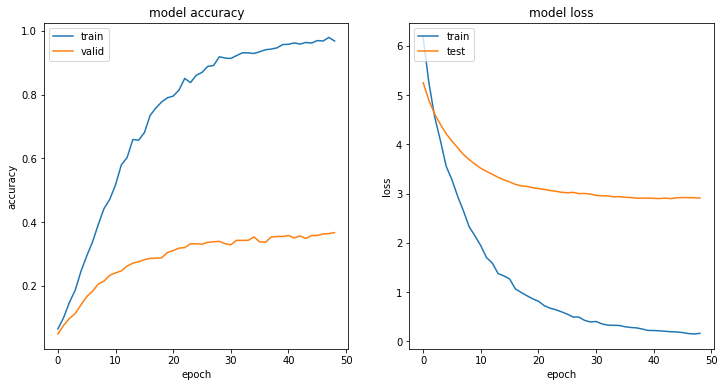

In [192]:
history_plot(vgg16_history)

In [73]:
!pip install -U efficientnet

  Using cached Keras_Applications-1.0.8-py3-none-any.whl (50 kB)


In [193]:
# 导入Efficient模块
from tensorflow.keras.applications.efficientnet import EfficientNetB4
import tensorflow.keras.backend as K

In [194]:
# 定义一个EfficientNet模型
def efficient_model(img_rows,img_cols):
  K.clear_session()
  x = Input(shape=(img_rows,img_cols,3))
  x = Lambda(imagenet_utils.preprocess_input)(x)
  
  base_model = EfficientNetB4(input_tensor=x,weights="imagenet",include_top=False,pooling="avg")
  x = base_model.output
  x = Dense(1024,activation="relu",name="fc1")(x)
  x = Dropout(0.5)(x)
  predictions = Dense(219,activation="softmax",name="predictions")(x)

  eB_model = Model(inputs=base_model.input,outputs=predictions,name="eB4")

  return eB_model

In [195]:
# 创建Efficient模型
img_rows,img_cols = 128 , 128
eB_model = efficient_model(img_rows,img_cols)

In [196]:
for i,layer in enumerate(eB_model.layers):
  print(i,layer.name)

0 input_1
1 lambda
2 rescaling
3 normalization
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block1b_dwconv
19 block1b_bn
20 block1b_activation
21 block1b_se_squeeze
22 block1b_se_reshape
23 block1b_se_reduce
24 block1b_se_expand
25 block1b_se_excite
26 block1b_project_conv
27 block1b_project_bn
28 block1b_drop
29 block1b_add
30 block2a_expand_conv
31 block2a_expand_bn
32 block2a_expand_activation
33 block2a_dwconv_pad
34 block2a_dwconv
35 block2a_bn
36 block2a_activation
37 block2a_se_squeeze
38 block2a_se_reshape
39 block2a_se_reduce
40 block2a_se_expand
41 block2a_se_excite
42 block2a_project_conv
43 block2a_project_bn
44 block2b_expand_conv
45 block2b_expand_bn
46 block2b_expand_activation
47 block2b_dwconv
48 block2b_bn
49 block2b_activation
50 block2b_se_squeeze
51 

In [197]:
eB_model.summary()

Model: "eB4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 128, 128, 3)  0           ['lambda[0][0]']                 
                                                                                                  
 normalization (Normalization)  (None, 128, 128, 3)  7           ['rescaling[0][0]']            

In [198]:
from tensorflow import keras

In [199]:
optimizer = tf.keras.optimizers.Adam(lr=0.0001)
batch_size = 32
epochs = 100
freeze_num = 469
eB_model_history  = fine_tune_model(eB_model,optimizer,batch_size,epochs,freeze_num)

Epoch 1/3
48/48 [==============================] - 25s 425ms/step - loss: 5.4278 - accuracy: 0.0052 - val_loss: 5.2907 - val_accuracy: 0.0167
Epoch 2/3
48/48 [==============================] - 19s 402ms/step - loss: 5.0274 - accuracy: 0.0607 - val_loss: 5.1351 - val_accuracy: 0.0472
Epoch 3/3
48/48 [==============================] - 19s 399ms/step - loss: 4.6821 - accuracy: 0.1324 - val_loss: 4.9586 - val_accuracy: 0.0731
Finish step_1
Epoch 1/100
48/48 [==============================] - ETA: 0s - loss: 4.3431 - accuracy: 0.2074
Epoch 00001: val_loss improved from inf to 4.75570, saving model to eB4.hdf5


/home/re6101029/miniconda3/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


48/48 [==============================] - 27s 445ms/step - loss: 4.3431 - accuracy: 0.2074 - val_loss: 4.7557 - val_accuracy: 0.0868 - lr: 1.0000e-04
Epoch 2/100
48/48 [==============================] - ETA: 0s - loss: 3.9776 - accuracy: 0.2694
Epoch 00002: val_loss improved from 4.75570 to 4.54395, saving model to eB4.hdf5
48/48 [==============================] - 20s 416ms/step - loss: 3.9776 - accuracy: 0.2694 - val_loss: 4.5440 - val_accuracy: 0.1065 - lr: 1.0000e-04
Epoch 3/100
48/48 [==============================] - ETA: 0s - loss: 3.6478 - accuracy: 0.3451
Epoch 00003: val_loss improved from 4.54395 to 4.32736, saving model to eB4.hdf5
48/48 [==============================] - 20s 418ms/step - loss: 3.6478 - accuracy: 0.3451 - val_loss: 4.3274 - val_accuracy: 0.1324 - lr: 1.0000e-04
Epoch 4/100
48/48 [==============================] - ETA: 0s - loss: 3.2955 - accuracy: 0.4103
Epoch 00004: val_loss improved from 4.32736 to 4.12470, saving model to eB4.hdf5
48/48 [==================

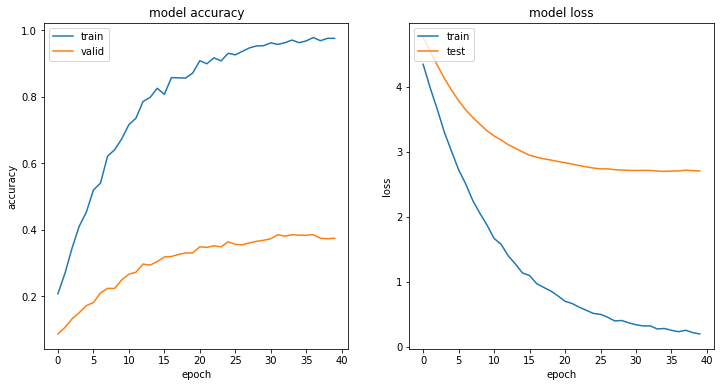

In [200]:
history_plot(eB_model_history)

In [201]:
# 定义双线性VGG16模型

from keras import backend as K

def batch_dot(cnn_ab):
    return K.batch_dot(cnn_ab[0], cnn_ab[1], axes=[1, 1])

def sign_sqrt(x):
    return K.sign(x) * K.sqrt(K.abs(x) + 1e-10)

def l2_norm(x):
    return K.l2_normalize(x, axis=-1)
 
 
def bilinear_vgg16(img_rows,img_cols):
    input_tensor = Input(shape=(img_rows,img_cols,3))
    input_tensor = Lambda(imagenet_utils.preprocess_input)(input_tensor)

    model_vgg16 = VGG16(include_top=False, weights="imagenet",
                        input_tensor=input_tensor,pooling="avg")
    
    cnn_out_a = model_vgg16.layers[-2].output
    cnn_out_shape = model_vgg16.layers[-2].output_shape
    cnn_out_a = Reshape([cnn_out_shape[1]*cnn_out_shape[2],
                         cnn_out_shape[-1]])(cnn_out_a)

    cnn_out_b = cnn_out_a

    cnn_out_dot = Lambda(batch_dot)([cnn_out_a, cnn_out_b])
    cnn_out_dot = Reshape([cnn_out_shape[-1]*cnn_out_shape[-1]])(cnn_out_dot)
 
    sign_sqrt_out = Lambda(sign_sqrt)(cnn_out_dot)
    l2_norm_out = Lambda(l2_norm)(sign_sqrt_out)
    
    fc1 = Dense(1024,activation="relu",name="fc1")(l2_norm_out)
    dropout = Dropout(0.5)(fc1)
    output = Dense(219, activation="softmax",name="output")(dropout)
    bvgg16_model = Model(inputs=model_vgg16.input, outputs=output,name="bvgg16")

    return bvgg16_model

In [202]:
# 创建双线性VGG16模型
img_rows,img_cols = 128 , 128
bvgg16_model = bilinear_vgg16(img_rows,img_cols)

In [203]:
for i,layer in enumerate(bvgg16_model.layers):
  print(i,layer.name)

0 input_2
1 lambda_1
2 block1_conv1
3 block1_conv2
4 block1_pool
5 block2_conv1
6 block2_conv2
7 block2_pool
8 block3_conv1
9 block3_conv2
10 block3_conv3
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_pool
16 block5_conv1
17 block5_conv2
18 block5_conv3
19 block5_pool
20 reshape
21 lambda_2
22 reshape_1
23 lambda_3
24 lambda_4
25 fc1
26 dropout_1
27 output


In [204]:
optimizer = tf.keras.optimizers.Adam(lr=0.0001)
batch_size = 32
epochs = 100
freeze_num = 25
bvgg16_history = fine_tune_model(bvgg16_model,optimizer,batch_size,epochs,freeze_num)

Epoch 1/3
48/48 [==============================] - 60s 1s/step - loss: 5.3703 - accuracy: 0.0300 - val_loss: 5.3471 - val_accuracy: 0.0518
Epoch 2/3
48/48 [==============================] - 60s 1s/step - loss: 5.2242 - accuracy: 0.1931 - val_loss: 5.2718 - val_accuracy: 0.0670
Epoch 3/3
48/48 [==============================] - 59s 1s/step - loss: 5.0162 - accuracy: 0.2818 - val_loss: 5.1636 - val_accuracy: 0.0944
Finish step_1
Epoch 1/100
48/48 [==============================] - ETA: 0s - loss: 4.7407 - accuracy: 0.4273
Epoch 00001: val_loss improved from inf to 5.03090, saving model to bvgg16.hdf5
48/48 [==============================] - 69s 1s/step - loss: 4.7407 - accuracy: 0.4273 - val_loss: 5.0309 - val_accuracy: 0.1065 - lr: 1.0000e-04
Epoch 2/100
48/48 [==============================] - ETA: 0s - loss: 4.4205 - accuracy: 0.5127
Epoch 00002: val_loss improved from 5.03090 to 4.87303, saving model to bvgg16.hdf5
48/48 [==============================] - 68s 1s/step - loss: 4.4205 -

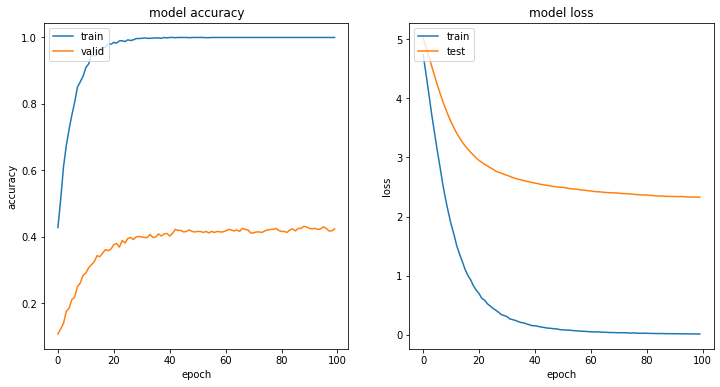

In [205]:
history_plot(bvgg16_history)